In [1]:
# imports and utility functions
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0, pi
from scipy.special import erfc
import seaborn

from utils import load_tissue_diel_properties
from utils import solve_bhte
from utils import register_sqrt_scale

In [2]:
# set context to `seaborn`
seaborn.set(style='whitegrid', context='paper', palette='colorblind', font='serif', font_scale=2)

In [3]:
# high-resolution rendering
%config InlineBackend.figure_format = 'retina'

In [4]:
# bhte constants for dry skin from https://itis.swiss/virtual-population/tissue-properties/database/
k = 0.37
rho = 1109.
C = 3391.
m_b = 1.8e-6

# Thermal response of human skin to microwave energy: A critical review

**Authors.** Kenneth R. Foster, Marvin C. Ziskin and Quirino Balzano

**Journal.** Health Phys. 111(6): 528-541; 2016

**DOI.** 10.1097/HP.0000000000000571

**Aim.** Review and modelling study of heating of tissue by microwave energy in the frequency range from 3 GHz through millimiter frequency range, up to 300 GHz motivated by the anticipated 5G communication technology deployment and its poorly researched potential hazard mechanisms. 

**Method.** Comprehensive survey of the available data on heating tissues with microwave energy in the millimeter-wave frequency spectrum; developement of a simple thermal model based on the Pennes' bioheat transfer equation without *post hoc* parameter adjustment; comparisson of existing data with model predictions.

**Results.** The simple model presented and solved both analytically and numerically (in 1-D and 2-D) presents successful approximation of thermal responses of tissue over a wide range of exposure conditions and is well-aligned with the available experimental data. However, one must be aware of assumptions made while developing this model: only the small irradiated area is considered so that the thermal conduction effects, which are essentially independent of physiological changes, e.g., thermoregulatory responses by means of blood perfusion gradient, predominated; exposure scenarios were of short duration so that the steady state was not reached, which further increase the relative importance of heat conduction and blood perfusion influence interplay; finally, the incident power densities were rather high, above rates of convective and radiative skin cooling, so that insulated boundary conditions did make a good approximation.

**Conclusion.** There is a great lack of data in the relevant literature on heating of human tissues, assuming it is the only detrimental effect on human tissue, by radio-frequency energy in the frequency range considered in the present study. The over-simplified one-dimensional thermal model strikes with surprisingly successful and acurate predictions of the thermal response in human tissue with no adjustment of model parameters, the problem is however, there are only few data to conduct tests on. The study has shown that the scaling properties of the Pennes' bioheat transfer equation and heat conduction equations can be useful in synthesizing thermal response of skin to radio-frequency exposures over wide ranges, and as such, this approach may be suitable for evaluation of safety limits for radiofrequency radiation and/or may be used as a analytical benchmark for more detailed numerical models.

---

**Model.** Pennes' bioheat transfer equation (BHTE) can be written as follows:

$$
k \nabla^2 T - \rho^2 C m_b T + \rho \mbox{SAR} = \rho C \frac{\partial T}{\partial t}
$$

where
- $T$ $[\mbox{°C}]$ is the temperature raise of the tissue above the baseline temperature (i.e., the temperature preceeding to radio-frequency exposure);
- $k$ $[\mbox{W/m°/C}]$ is the thermal conductivity of the tissue;
- $\mbox{SAR}$ $[\mbox{W/kg}]$ is the microwave power deposition rate;
- $C$ $[\mbox{Ws/kg/°C}]$ is the heat capacity of the tissue;
- $\rho$ $[\mbox{kg/m}^3]$ is the tissue density;
- $m_b$ $[\mbox{m}^3\mbox{s/kg}]$ is the volumetric perfusion rate of blood, which should be interpreted as an empirical parameter and not literally as a capillary perfusion rate;

with insulated boundary conditions as a conservative assumption.
The choice of boundary conditions is justified because the rate of conduction of heat from microwave exposure into deeper layers of skin can be expected to be well below the rate of heat loss from skin to the environment:

$$
k \frac{\partial T}{\partial z} > h(\Delta T_{sur} - T_{air})
$$

where
- $T_{sur}$ $[\mbox{°C}]$ and $T_{air}$ $[\mbox{°C}]$ are the temperatures of the tissue surface and surrounding air;
- $\partial T / \partial z$ is the temperature gradient at the surface;
- $h$ $[\mbox{W/m/°C}]$ is the heat transfer coefficient (of the order $[1-10] \mbox{ W/m/°C}$).

Under the assumption of plane wave radio-frequency energy on a uniform plane of tissue with normal incidence, the source term in BHTE can be written as follows:

$$
\mbox{SAR} = \frac{I_0 T_{tr}}{\rho L} e^{-z/L}
$$

where
- $I_0$ $[\mbox{W/m^2}]$ is the incident power density on the tissue;
- $T_{tr}$ is the energy transmission coefficient into the tissue;
- $L$ $[\mbox{m}]$ is the energy penetration depth into tissue, which is defined as the distance beneath the surface at which the $\mbox{SAR}$ has fallen to a factor of $1/e$ below that at the surface ($z$-direction).

Even though the validity of the BHTE is discussed from the first release of the Pennes' paper in 1948, the overall relevant literature support the use of the BHTE to predict the thermal response of the tissue to radiofrequency exposure. However, the extent of the validation of a thermal model based on the BHTE is limited mostly because of the relativly poor knowledge on the variability of parameters. The standard reported parameters do not include thermoregulatory variations in the blood flow or convective cooling near thermally significant blood vessles, so the BHTE will likely output conservative results (overestimate temperature increases). Additional caveat is thath the blood flow parameter, $m_b$, which largely determines the steady state temperature increase, is subject to intersubject and intrasubject variation. This leads to significant errors of the BHTE solution near thermally significant blood vessels as described in "Recent developments in modelling heat transfer in blood perfused tissues", 1994, IEEE Trans Biomed Eng by Arkin et al.

In [5]:
# frequency range 1 GHz up to 100 GHz
f = np.arange(1., 100.) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

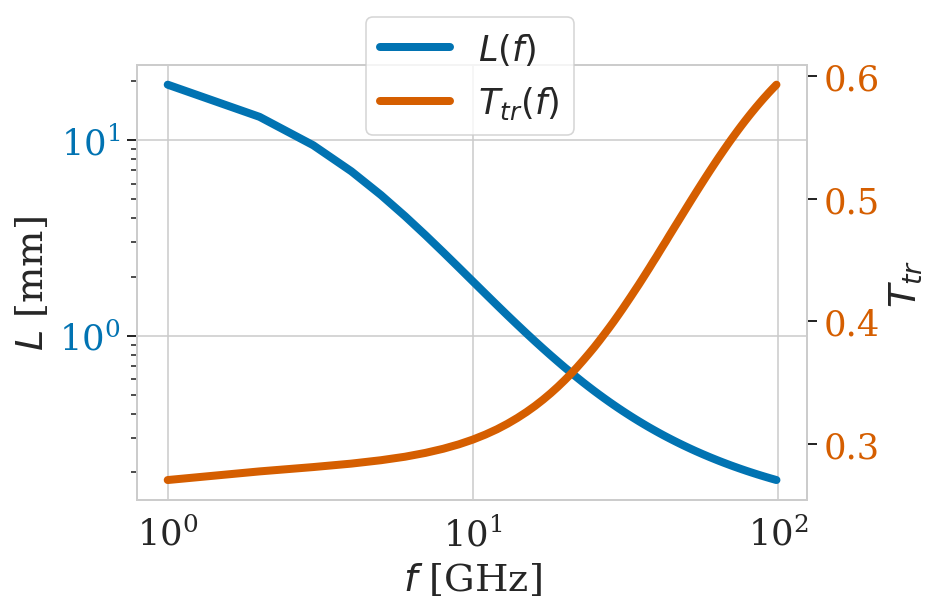

In [6]:
# Fig. 1. in the paper - penetration depth and transmission coefficient over range of frequencies
fig, ax1 = plt.subplots()
ax1.plot(f / 1e9, pen_depth * 10 * 100, 'b-', lw=4, label='$L(f)$')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set(xscale='log', yscale='log', xlabel='$f$ [GHz]', ylabel='$L$ [mm]')
ax2 = ax1.twinx()
ax2.plot(f / 1e9, np.abs(T_tr), 'r-', lw=4, label='$T_{tr}(f)$')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set(xscale='log', ylabel='$T_{tr}$')
ax2.grid(False)
fig.legend(loc='upper center');

**Scaling properties of a 1-D version of the presented model: semi-infinite plane exposed to incident plane wave.** The thermal response of the 1-D model is characterized by two time scales representing heat transport by blood perfusion and thermal conduction, respectively:

$$
\tau_1 = \frac{1}{m_b \rho}; \qquad \tau_2 = \frac{L^2}{\alpha};
$$

where $\alpha = k / \rho C$ is the thermal diffusivity.

In [7]:
# intrinsic time scale of the BHTE representing heat transport by blood perfusion
tau_1 = 1 / (m_b * rho)

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# effective time scale of the BHTE
tau_eff = (tau_2 - np.sqrt(tau_1 * tau_2)) / (tau_2 / tau_1 - 1)

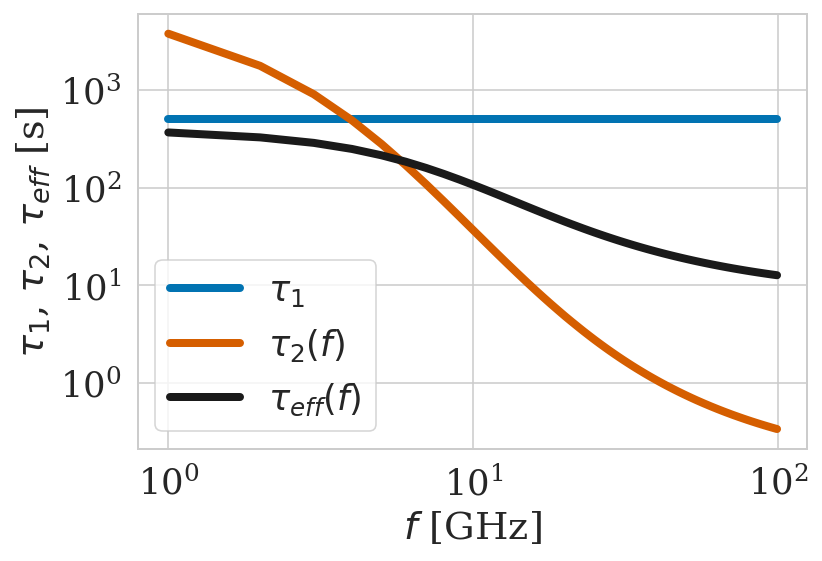

In [8]:
# Fig. 2. in the paper - time scales over range of frequencies
fig, ax = plt.subplots()
ax.plot(f / 1e9, np.ones_like(f) * tau_1, 'b-', lw=4, label='$\\tau_1$')
ax.plot(f / 1e9, tau_2, 'r-', lw=4, label='$\\tau_2(f)$')
ax.plot(f / 1e9, tau_eff, 'k-', lw=4, label='$\\tau_{eff}(f)$')
ax.set(xscale='log', yscale='log',
       xlabel='$f$ [GHz]', ylabel='$\\tau_1$, $\\tau_2$, $\\tau_{eff}$ [s]')
ax.legend();

For low perfusion rates ($m_b \rightarrow 0$), BHTE approaches the simple heat conduction equation.
In that case, the transient solution for the surface temperature $T_{sur}$ is readily available, assuming $L \rightarrow 0$:

$$
T_{sur}(t) = C_1 \sqrt{t} - C_2 \big( 1 - e^{t/\tau_2} erfc \sqrt{t/\tau_2} \big)
$$

where
* $C_1 = \frac{2 I_0 T_{tr}}{\sqrt{\pi k \rho C}} = 9.54 \cdot 10^{-4} I_0 T_{tr} \mbox{ °C/s}^{0.5}$;
* $C_2 = \frac{I_0 T_{tr} L}{k} = 2.7 \cdot I_0 T_{tr} \mbox{ °C}$.

The term $C_2$ rapidly approaches zero as $t>\tau_2$ and describes an early transient effect associated with diffusion of heat over the energy penetration depth.
In the absence of a perfusion term, after an initial transient, $T_{sur}$ increases without limit with $t^{0.5}$.

In [9]:
# frequency
f = 6e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# I_0 T_Tr = 10 W/m^2 at 6 GHz for a given "conduction-only" model
I_0 = 10 / T_tr

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# exposure time in seconds
dt = 1
t = np.arange(0, 16000, dt)

# closed-form solution of the 1-D BHTE with no blood perfusion considered;
# appropriate approximation for either short-term exposure or small exposure areas
C_1 = 2 * I_0 * T_tr / np.sqrt(pi * k * rho * C)
C_2 = I_0 * T_tr * pen_depth / k
T_sur = C_1 * np.sqrt(t) - C_2 * (1 - np.exp(t / tau_2) * erfc(np.sqrt(t / tau_2)))

# numerical solution in time via FFT with blood perfusion > 0
N = 11
T_sur_mb_1 = solve_bhte(t, N, pen_depth, k, rho, C, m_b, I_0, T_tr)
T_sur_mb_2 = solve_bhte(t, N, pen_depth, k, rho, C, m_b/3, I_0, T_tr)

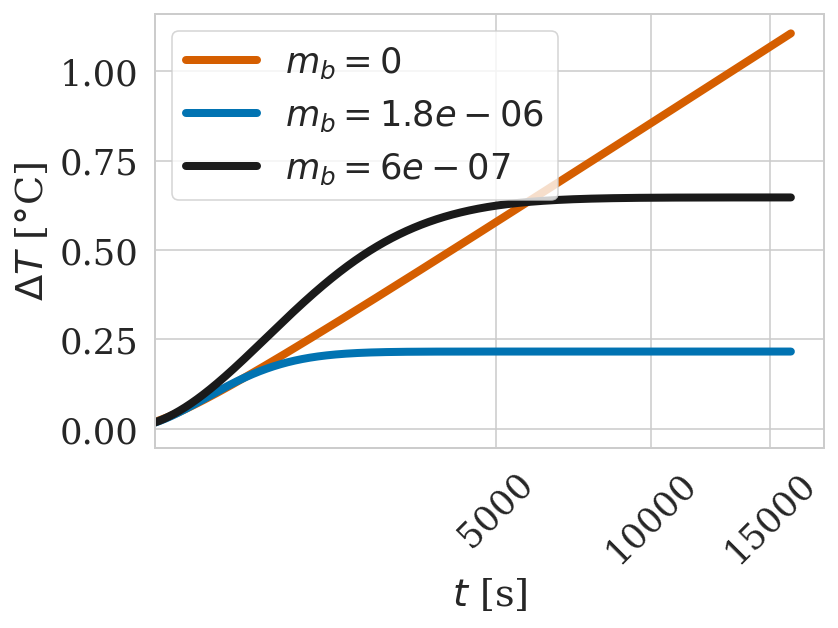

In [10]:
# Fig. 3. in the paper - temperature raise in time (x-axis is square-root scaled)
register_sqrt_scale()

fig, ax = plt.subplots()
ax.plot(t, T_sur, 'r', lw=4, label=f'$m_b = 0$')
ax.plot(t, T_sur_mb_1[:, 0], 'b', lw=4, label=f'$m_b = {m_b}$')
ax.plot(t, T_sur_mb_2[:, 0], 'k', lw=4, label=f'$m_b = {m_b/3}$')
ax.set(xscale='sqrt', xlabel='$t$ [s]', ylabel='$\\Delta T$ [°C]')
ax.tick_params(axis='x', labelrotation=45)
ax.legend();

In the presence of blood flow, where $m_b > 0$, there is no known closed-form analytic solution in time.
However, as $T_{sur}$ approaches a steady state value $T_{ss}$ may be written as the product of the $\mbox{SAR}$ at the surface and an effective thermal time constant $\tau_{eff}$, as follows:

$$
T_{ss} = \frac{\mbox{SAR}_0}{C} \tau_{eff}
$$

where $\tau_{eff} = \frac{\tau_2 - \sqrt{\tau_1 \tau_2}}{\tau_2 / \tau_1 - 1}$ and $\mbox{SAR}_0 = \frac{I_0 T_{tr}}{\rho L}$.

In the limiting cases there $\tau_2 >> \tau_1$ and $\tau_2 << \tau_1$, $\tau_{eff}$ approaches the asymptotic values of $\tau_1$ and $(\tau_1 \tau_2)^{0.5}$, respectively, and $T_{ss}$ takes on the limiting values:

$$
T_{ss} \rightarrow \frac{I_0 T_{tr}}{\rho \sqrt{C m_b k}}, \quad \tau_1 / \tau_2 \rightarrow \infty
$$

$$
T_{ss} \rightarrow \frac{I_0 T_{tr}}{L C m_b \rho^2}, \quad \tau_1 / \tau_2 \rightarrow 0
$$

For the mmWave frequency range, of interest in this paper, $\tau_1 >> \tau_2$, and the steady state increase in temperature at the surface for the 1-D case is best described above for the associated case, showing a modest dependence on the blood perfusion term.

The scaling properties of the BHTE in the spatial domain can be investigated with reference to the Green's function, where the Green's function decays exponentially with distance with two intrinsic distance scales,
* the one that accounts for the smoothing effect of blood perfusion, and

$$
R_1 = \frac{\sqrt{k}}{\rho \sqrt{m_b c}}
$$

* the one that represents a measure of the distance that heat diffuses in time, $t$,

$$
R_2 = \sqrt{4 \alpha t} \sim 0.5 \sqrt{t} \mbox{ mm s}^{-0.5}
$$

# Thermal modelling for the next generation of radiofrequency exposure limits: Commentary

**Authors.** Kenneth R. Foster, Marvin C. Ziskin and Quirino Balzano

**Journal.** Health Phys. 113(1): 41-53; 2017

**DOI.** 10.1097/HP.0000000000000671

**Aim.** Review/commentary/analysis of the current* guideliness. The overall goal is to evaluate two sets of guidelines for human exposure to radiofrequency energy, focusing on the frequency range above the transition frequency at 3 - 10 GHz where the reviewed guidelines change their basic restrictions from specific absorption rate to incident power densitiy, throughout the mmWave range up to 300 GHz. Important caveat is that the authors consider exclusively reported thermal effects as potential hazards to human tissue and do not comment on the contentious issue of non-thermal effects, which are scientifically poorly supported.

**Method.** The analysis is based on a simple thermal model based on Pennes' bioheat transfer equation (BHTE) assuming purely surface heating, which is an excellent approximation for millimeter waves (30 - 300 GHz) but overestimetas temperature increase at lower frequencies. The subject to heating is an adiabatic half plane of tissue, where it is assumed that no heat in the skin is lost to the surrounding environment.

**Results.** Surface heating approximation is excellent for mmWave range, where the energy penetration depth is < 1mm but, as expected, fails progressively at lower frequences. The conduction-only model can be well approximation to the BHTE for small irradiated areas or for short times in the step response; for longer exposure times and larger exposed areas it will fail progressively. The simple model could be used for relatively specific scenarios and as a benchmark for more complex and realistic numerical simulations. Based on the model and the current* guidelines, authors infere number of recommendations and provide an in-depth discussion on the subject of basic restrictions and reference levels for radiofrequency exposure.

**Conclusion.** Overall conclusion is that there exists lack of consistency in guidelines regarding averaging times and averaging area, which are not consistent with scaling characteristics of the BHTE. Further more, reviewed guidelines* are highly conservative relative to ther stated goals of limiting temperature in tissue.

(*) by "current" and "reviewed" guidelines, it is reffered to the International Commision of Nonionizing Radiation Protection (ICNIRP 1998) and the Institute of Electrical and Electronics Engineers (IEEE 2005) guidelines, both revised and updated as of 11-Feb-21. 

In [11]:
# incident power density
I_0 = 100

# frequencies
f = np.array([1, 3, 10]) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# closed-form solution for uniformly irradiated plane, no blood perfusion (m_b = 0),
# and finite energy penetration depth (pen_depth > 0)
C_1 = 2 * I_0 * T_tr / np.sqrt(pi * k * rho * C)
C_2 = I_0 * T_tr * pen_depth / k
t = np.linspace(0, 10000)
_t = np.column_stack((t, t, t))
T_sur = C_1 * np.sqrt(_t) - C_2 * (1 - np.exp(_t / tau_2) * erfc(np.sqrt(_t / tau_2)))

# numerical solution
N = 10
T_sur_num = []
for _pen_depth, _T_tr in zip(pen_depth, T_tr):
    T_sur_num.append(solve_bhte(t, N, _pen_depth, k, rho, C, m_b, I_0, _T_tr))

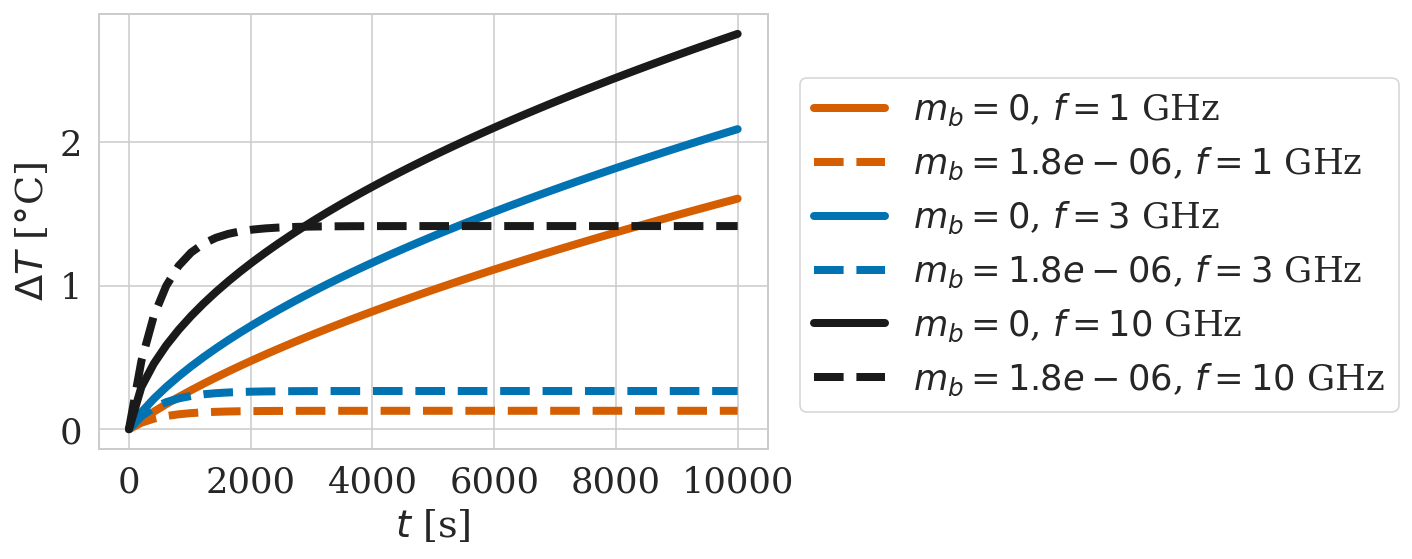

In [12]:
# Fig. A1. in the paper - temperature raise in time
fig, ax = plt.subplots()
ax.plot(t, T_sur[:, 0], 'r', lw=4, label=f'$m_b = 0$, $f = 1$ GHz')
ax.plot(t, T_sur_num[0][:, 0], 'r--', lw=4, label=f'$m_b = {m_b}$, $f = 1$ GHz')
ax.plot(t, T_sur[:, 1], 'b', lw=4, label=f'$m_b = 0$, $f = 3$ GHz')
ax.plot(t, T_sur_num[1][:, 0], 'b--', lw=4, label=f'$m_b = {m_b}$, $f = 3$ GHz')
ax.plot(t, T_sur[:, 2], 'k', lw=4, label=f'$m_b = 0$, $f = 10$ GHz')
ax.plot(t, T_sur_num[2][:, 0], 'k--', lw=4, label=f'$m_b = {m_b}$, $f = 10$ GHz')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$\\Delta T$ [°C]')
fig.legend(bbox_to_anchor=(1.65, 0.8));

In [13]:
# incident power density
I_0 = 100

# frequencies
f = np.array([3, 10, 30, 100]) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# closed-form solution for uniformly irradiated plane, surface heating (pen_depth = 0), finite blood perfusion (m_b > 0)
# frequency independent scenario because of the purely surface heating
R_1 = np.sqrt(k) / (rho * np.sqrt(m_b * C))
T_sur_ss = I_0 * T_tr * R_1 / k

# (relevant parts of the) Table A1.
print('f [GHz] \t L [mm] \t T_tr \t\t T_sur [°C]')
for _f, _pen_depth, _T_tr, _T_sur_ss in \
        zip(f, pen_depth, T_tr, T_sur_ss):
    print(f'{_f / 1e9} \t\t '
          f'{round(_pen_depth * 1000, 2)} \t\t '
          f'{round(_T_tr, 2)} \t\t '
          f'{round(_T_sur_ss, 2)}')

f [GHz] 	 L [mm] 	 T_tr 		 T_sur [°C]
3.0 		 9.42 		 0.28 		 0.53
10.0 		 1.9 		 0.3 		 0.58
30.0 		 0.43 		 0.4 		 0.77
100.0 		 0.18 		 0.59 		 1.13


# Modelling tissue heating from exposure to radiofrequency energy and relevance of tissue heating to exposure limits: Heating factor

**Authors.** Kenneth R. Foster, Marvin C. Ziskin, Quirino Balzano and Giorgi Bit-Babik

**Journal.** Health Phys. 115(2): 295-307; 2018

**DOI.** 10.1097/HP.0000000000000854

**Aim.** To review several detailed thermal modelling studies to compare a recently introduced dosimetric quantitiy, the heating factor, across different exposure conditions as related to the peak temperature rise in tissue that would be permitted by limits for local body exposure.

**Method.** Pennes' bioheat transfer equation is used as a simplified 1-D thermal model subjected to convective boundary condition at the tisue-air interface. The specific absorption rate at any point in the tissue is defined as the ratio of the product between the squared value of the root-mean-square electric field strength and the electrical conductivity, and the tissue density. Heating factor is further defined as the ratio of the peak steady state increase in tissue temperature to the peak mass-averaged specific absorption rate in the body, where the heating factor depends directly on the size and the shape of the averaging volume for the specific absorption rate and is strongly influenced by the heat transfer characteristics in the region of the highest specifici absorption rate. In this study, the mass-averaged specific absorption rate over a cubic volume of a 10 g is used as the referenced averaging spatial feature.

**Results.**

**Conclusion.** The heating factor is a robust measure of the relation between the incident power density for frequencies above the transition frequency of 6 GHz* or the peak spatial SAR for lower frequencies (100 kHZ - 6 GHz) and the peak increase in temperature. However, additional information on the location and magnitude of the temperature increase in the body is needed to assess potential (thermal) hazards. Fruthermore, the simple 1-D Pennes' bioheat transfer equation thermal model, used in the previous two studies by the authors, could potentially serve as the benchmark for more complex numerical thermal models and could be useful for revising and updating radiofrequency exposure limits because of its simplicity and interpretability. However, this model and its analytical solutions for different scenarios require additional experimental validation including the effects of variability in tissue blood perfusion, possible thermoregulatory responses of the body to radiofrequency heating, and other important factors. Finally, more experimental data are needed, especially in the mmWave range spectrum, where, besides thermal, non-thermal reported biological effects, should also be considered as potential hazard to human tissue and the overall health.

(*) Authors do not explicitly state the value of the transition frequency, aligned both in ICNIRP 2020 and FCC to the 6 GHz. Rather, they take a range 3 - 10 GHz, depending on the guidline/standard, because the study predates newly published standards.

---

**Baseline model.** Assumend subject of heating is insulated half-space, i.e., adiabatic boundary condition with $h=0$ in

$$
k \frac{\partial T}{\partial z} = -h (T_{sur} - T_{air}),
$$

where $k$ is the thermal conductivity of the tissue, h is the heat transfer coefficient (typically in the range $5$ to $10 \mbox{W/°C m}^2$ for ordinary room environmental conditions) and $T_{sur}$ and $T_{air}$ are the surface and surrounding air temperature, respectively.

For the case outlined above, the steady state increase in surface temperature, $T_{ss}$ can be wrritten as the product of the specific absorption rate at the surface of the tissue, $\mbox{SAR}_0$, and the effective time constant, $\tau_{eff}$ as follows:

$$
T_{ss} = \frac{\mbox{SAR}_0}{C} \tau_{eff}
$$

where $\tau_{eff} = \frac{\tau_2 - \sqrt{\tau_1 \tau_2}}{\tau_2/\tau_1 - 1}$.

The limiting values of $T_{ss}$ are:
* low frequency limit, $\tau_2  >> \tau_1$,
    $$
    T_{ss} \rightarrow \frac{I_0 T_{tr}}{L C m_b \rho^2};
    $$
* high frequency limit, $\tau_1  >> \tau_2$,
    $$
    T_{ss} \rightarrow \frac{I_0 T_{tr}}{\rho \sqrt{C m_b k}}.
    $$

Transition frequency (low $\rightarrow$ high) is considered to be $\sim 3 \mbox{ GHz}$ in this paper.

With regards to the absorption rate, the mass-averaged peak surface specific absorption rate, $\mbox{psSAR}$, in a tissue of thickness, $d$, immediately beneath the surface is defined as:

$$
\mbox{psSAR}_d = \frac{\mbox{SAR}_0}{d} L(1 - e^{-d/L})
$$

where $L$ is the effective energy penetration depth (half of the commonly reported wave penetration depth).

Finally, the heating factor, $H$, is defined as follows:

$$
H = \frac{\Delta T_{max}}{\mbox{psSAR}_d} [\mbox{ °C kg/W}]
$$

or, more explicitly:

$$
H = \frac{\tau_{eff} d}{C L (1 - e^{-d/L})}
$$

For the limiting case of surface exposure when $d << L$, the heating factor approaches to:

$$
H = \frac{1}{C m_b \rho},
$$

where this expression can be obtained directly from steady state solution to the bioheat transfer equation for cases where thermal conduction is negligible compared to heat convection by blood flow, which is more likely to apply at low frequencies with large L.

In [14]:
# frequencies
f = np.array([1, 3, 10]) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# intrinsic time scale of the BHTE representing heat transport by blood perfusion
tau_1 = 1 / (m_b * rho)

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# effective time scale of the BHTE
tau_eff = (tau_2 - np.sqrt(tau_1 * tau_2)) / (tau_2 / tau_1 - 1)

# SAR at the surface for temperature increase of 1°C
SAR_0 = C / tau_eff

# incident power densitiy at the surface for temperature increase of 1°C
I_0  = SAR_0 * rho * pen_depth / T_tr

# averaging mass in grams
m_1 = 1/1000
m_10 = 1/100

# implicit expression for the spatial dimension of the shell underneath the surface considering given volume
d_1 = np.cbrt(m_1 / rho)
d_10 = np.cbrt(m_10 / rho)

# heating factor
H_1g = tau_eff * d_1 / (C * pen_depth * (1 - np.exp(-d_1/pen_depth)))
H_10g = tau_eff * d_10 / (C * pen_depth * (1 - np.exp(-d_10/pen_depth)))

# Table 3. Heating factors, baseline model.
print('f [GHz]  L [mm]  T_tr    tau_eff [s]  I_0 T_tr [W/m2]  H_1g [kg°C/W]  H_10g [kg°C/W]')
for _f, _pen_depth, _T_tr, _I_0, _tau_eff, _H_1g, _H_10g in \
        zip(f, pen_depth, T_tr, I_0, tau_eff, H_1g, H_10g):
    print(
        f'{_f / 1e9} \t '
        f'{round(_pen_depth * 1000, 2)} \t '
        f'{round(_T_tr, 2)} \t '
        f'{round(_tau_eff, 2)} \t'
        f'{round(_I_0 * _T_tr, 4)} \t '
        f'{round(_H_1g, 3)} \t\t '
        f'{round(_H_10g, 2)}')

f [GHz]  L [mm]  T_tr    tau_eff [s]  I_0 T_tr [W/m2]  H_1g [kg°C/W]  H_10g [kg°C/W]
1.0 	 19.22 	 0.27 	 366.95 	197.0237 	 0.138 		 0.18
3.0 	 9.42 	 0.28 	 287.03 	123.4181 	 0.135 		 0.21
10.0 	 1.9 	 0.3 	 106.65 	66.9584 	 0.161 		 0.34
